In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
%matplotlib inline

In [2]:
RANDOM_STATE = 1111
EPOCH_NUMBER = 50
LEARNING_RATE = 0.03
NUM_FEATURES = 2
NUM_CLASSES = 3
NUM_EXAMPLES = 500
torch.manual_seed(RANDOM_STATE)

In [3]:
def plot_data(x1, x2, y, title):
    """
    Plots scatterplot
    """
    plt.clf()
    plt.title(title)
    plt.scatter(x1, x2, marker='o', c=y, s=20, edgecolor='k')
    plt.show()

def plot_variable(variable, title):
    """
    Plots 1d variable
    """
    plt.clf()
    plt.title(title)
    plt.plot(variable)
    plt.show()

In [4]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [5]:
X1, Y1 = make_classification(n_samples=NUM_EXAMPLES, n_features=NUM_FEATURES, n_redundant=0, 
                             n_informative=NUM_FEATURES, n_clusters_per_class=1, n_classes=NUM_CLASSES, 
                             random_state=RANDOM_STATE)

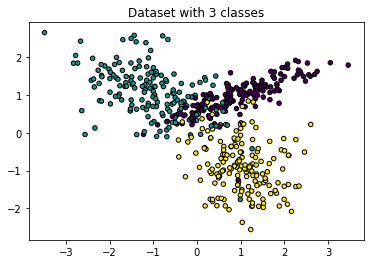

In [6]:
plot_data(X1[:, 0], X1[:, 1], Y1, "Dataset with 3 classes")

In [7]:
def desicion_boundary(x1, x2, y, clf):
    """
    Utility function to plot desicion boudary of a classifier
    """
    plt.clf()
    xx, yy = make_meshgrid(x1, x2)
    plot_contours(plt, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(x1, x2, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(350, 2)
(350,)
(150, 2)
(150,)


In [9]:
# Will create simple Logistic Regression classifier to have smth as a baseline.
clf = LogisticRegression()
clf.fit(X_train, y_train) 

# pedict 
test_results = clf.predict(X_test)
acc = accuracy_score(y_test, test_results)
print("LR acc ", acc)

LR acc  0.853333333333


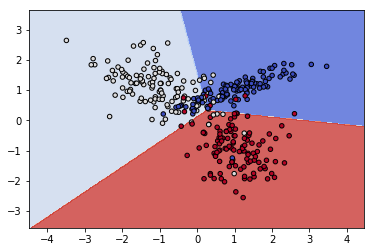

In [10]:
desicion_boundary(X_train[:, 0], X_train[:, 1], y_train, clf)

In [11]:
class Net(nn.Module):
    def __init__(self, layer_sizes, num_classes):
        # Constructor contains layers of a network
        super().__init__()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

        self.layers = []
        for i in range(len(layer_sizes) - 1):  # last layer has different activation
            print("layer_size", layer_sizes[i], layer_sizes[i + 1])
            fc = nn.Linear(layer_sizes[i], layer_sizes[i + 1], bias=True)
            self.layers.append(fc)
    
        self.last = nn.Linear(layer_sizes[-1], num_classes)

    def forward(self, x):
        for i, el in enumerate(self.layers):
            if i == 0:
                out = el(x)
            else:
                out = el(out)
            out = self.relu(out)
        out = self.last(out)
        out = self.softmax(out)
        return out
    
    def predict(self, x):
        # Just a convenient way to get preditions in sklearn's fashion
        x = Variable(torch.Tensor(x))
        res = self.__call__(x)
        data = res.data.numpy()
        classes = data.argmax(axis=1)
        return classes

In [12]:
def train(net, loss_fn, opt, x, y, epoch=EPOCH_NUMBER):
    """
    Training of a network is done here for EPOCH_NUMBER of steps
    """
    history_l = []
    history_a = []
    for e in range(epoch):
        inputs = Variable(torch.Tensor(x))
        labels = Variable(torch.LongTensor(y))

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        loss_val = loss.data.numpy()
        loss_val.ravel()
        np_outputs = outputs.data.numpy()
        classes = np_outputs.argmax(axis=1)
        current_accuracy = accuracy_score(y, classes)
        history_a.append(current_accuracy)
        history_l.append(loss_val[0])

    return history_l, history_a

In [13]:
network = Net([2, 10], 3)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=LEARNING_RATE)

layer_size 2 10


In [14]:
history_loss, history_acc = train(network, loss_function, optimizer, X_train, y_train, epoch=EPOCH_NUMBER)

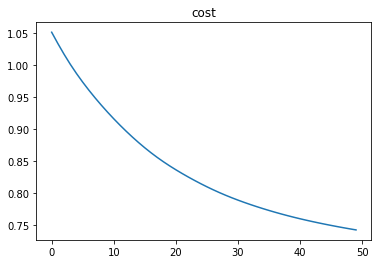

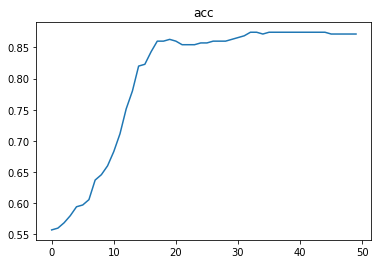

Final acc 0.871428571429


In [15]:
plot_variable(history_loss, "cost")
plot_variable(history_acc, "acc")
print("Final acc", history_acc[-1])

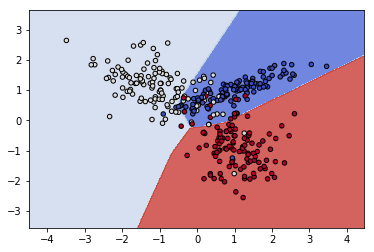

In [16]:
desicion_boundary(X_train[:, 0], X_train[:, 1], y_train, network)

In [17]:
predictions = network.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)
print("Test acc", test_accuracy)

Test acc 0.84
